In [1]:
# Initialize Otter
import otter
grader = otter.Notebook('hw5.ipynb')

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name='si'></a>
<hr>
rubric={points:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **You may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Upload the .ipynb file to Gradescope.
- **If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb.** 
- Make sure that your plots/output are rendered properly in Gradescope.

**Score**: 0.4047619047619047

**Metric**: F1

## Imports

In [2]:
# Built-in
import os
import sys
from itertools import chain
from functools import partial
from pathlib import Path
from joblib import Memory
from tempfile import mkdtemp

# Data Wrangling
import numpy as np
import pandas as pd

# Visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-processing
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    train_test_split, 
    cross_validate, 
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OrdinalEncoder, 
    OneHotEncoder, 
    StandardScaler, 
    KBinsDiscretizer,
    FunctionTransformer
)

# Models
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

# Metrics
import eli5
import shap
from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    classification_report
)

# Helper Functions
recall_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
f1_scorer = make_scorer(f1_score)

def pr_cross_validation(estimator, X, y, n_jobs = None, cv = 5):
    scores = pd.DataFrame.from_records(
        cross_validate(
            estimator, 
            X, 
            y,
            cv = cv, 
            scoring = {
                'recall': recall_scorer,
                'precision': precision_scorer,
                'f1': f1_scorer
            },
            return_train_score = True,
            n_jobs = n_jobs
        ),
    )
    return scores
    

def precision_recall_plot(estimator, X, truth, ax):
    probabilities = estimator.predict_proba(X)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(truth, probabilities)
    
    ax.plot(thresholds, precision[:-1], color = 'salmon', label = 'Precision')
    ax.plot(thresholds, recall[:-1], color = 'skyblue', label = 'Recall')
    ax.legend(loc='lower left')
    

def report(truth, preds, threshold):
    print(pd.DataFrame(confusion_matrix(truth, preds > threshold)), end = '\n\n')

    print(classification_report(
        truth,
        preds > threshold,
        target_names = ['No Default', 'Default']
))
    
    
def column_concatenation(df1, df2):
    return pd.concat([df1, df2], axis = 1)


def class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight(
        class_weight = 'balanced',
        classes = classes,
        y = y
    )
    return dict(zip(classes, weights))


def pr_random_search_cv(pipe, X, y, param_grid):
    random_search = RandomizedSearchCV(
        pipe,
        param_distributions = param_grid,
        n_iter = 20,
        cv = 5,
        n_jobs = -1,
        random_state = 42,
        scoring = {
            'recall': recall_scorer,
            'precision': precision_scorer,
            'f1': f1_scorer
        },
        return_train_score = True,
        refit = 'f1'
    )
    return random_search.fit(X, y)

## Introduction <a name='in'></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this 'project' question is different from other assignments. It'll be up to you to decide when you're 'done' -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps 'a few hours' (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name='1'></a>
<hr>
rubric={points:3}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled 'default.payment.next.month' in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

<div class='alert alert-warning'>
    
Solution_1
    
</div>

In [3]:
credit_card_clients_df = pd.read_csv(Path.cwd() / 'data' / 'UCI_Credit_Card.csv', index_col = 'ID')

### Problem

Credit card clients borrow money with the assumed intent to pay the debt, on occassion with interest. It is in the banks, or creditors, interest to determine which clients are most likely to default, cease payments, on their creidt. Therefore, developing a machine learning algorithm that is able to predict if a client will default on their credit may help the bank project their returns.

### Plan

A binary classification model will be trained using demographic, billing, and payment records of the Taiwanese credit card users. 

There will be a focus on the F1 score for this project. A high recall should be maintain so that there is a strong ability to capture clients that are truly likely to default, making potential financial forecasting reports more accurate. However, their should also be a high level of precision since it may not be desireable to report greater losses than what expected. It is challenging to optimize for both recall and precision given that their scale inversely. The F1 score provides a combination of precision and recall, helping identify models that perform well for both metrics.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name='2'></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class='alert alert-warning'>
    
Solution_2
    
</div>

In [4]:
train_df, test_df = train_test_split(credit_card_clients_df, test_size = 0.3, random_state = 123)
train_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
16396,320000.0,2,1,2,36,0,0,0,0,0,...,19370.0,10155.0,3788.0,5000.0,5018.0,1000.0,3000.0,0.0,7013.0,0
21449,440000.0,2,1,2,30,-1,-1,-1,0,0,...,171244.0,150897.0,117870.0,612.0,87426.0,130007.0,3018.0,15000.0,51663.0,0
20035,160000.0,2,3,1,44,-2,-2,-2,-2,-2,...,-18.0,-18.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25756,120000.0,2,2,1,30,0,0,0,0,0,...,103058.0,71095.0,47379.0,3706.0,5502.0,4204.0,3017.0,2005.0,1702.0,0
1439,50000.0,1,2,2,54,1,2,0,0,0,...,27585.0,27910.0,27380.0,0.0,1400.0,1200.0,1500.0,1000.0,1500.0,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name='3'></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class='alert alert-warning'>
    
Solution_3
    
</div>

### EDA Helper Functions and Constants

In [5]:
DEFAULT_COLUMN_NAME = 0
MONTHS = ('September', 'August', 'July', 'June', 'May', 'April')
STYLE = {'color': 'salmon', 'edgecolor': 'black'}
STACKED_BAR_STYLE = {
    'legend': False, 
    'stacked': True, 
    'edgecolor': 'black', 
    'color': {
        0: 'salmon', 
        1: 'skyblue'
    }
}


def stacked_ratios(df, x, stacker):
    proportions = df[[x, stacker]].groupby(x).value_counts(normalize = True)
    pivot_table = proportions.reset_index().pivot(
        index = x,
        columns = stacker,
        values = DEFAULT_COLUMN_NAME
    )
    return pivot_table


def quantiles(arr, step):
    return [arr.quantile(val) for val in np.arange(step, 1 + step, step)]


def quantile_encoder(value, quantiles):
    for idx, quantile in enumerate(quantiles):
        if value <= quantile:
            break
    return idx


def quantile_binner(series, quantiles):
    binner = partial(quantile_encoder, quantiles = quantiles)
    return series.apply(binner).astype('category')
    
    
def binner(arr, bins):
    return pd.cut(arr, bins)

### Are there null values present in the data set?

The `pandas.DataFrame.info` method also informs us that there are no empty values in our data set, since the outputted `Non-Null Count` column is equal to the number of rows in `train_df`.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 16396 to 19967
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   21000 non-null  float64
 1   SEX                         21000 non-null  int64  
 2   EDUCATION                   21000 non-null  int64  
 3   MARRIAGE                    21000 non-null  int64  
 4   AGE                         21000 non-null  int64  
 5   PAY_0                       21000 non-null  int64  
 6   PAY_2                       21000 non-null  int64  
 7   PAY_3                       21000 non-null  int64  
 8   PAY_4                       21000 non-null  int64  
 9   PAY_5                       21000 non-null  int64  
 10  PAY_6                       21000 non-null  int64  
 11  BILL_AMT1                   21000 non-null  float64
 12  BILL_AMT2                   21000 non-null  float64
 13  BILL_AMT3                  

### Are there missing values encoded as `0` in categorical variables? (Assumption: Missing values being encoded as `0`, when `0` has not stated meaning.)

There are categorical columns that have values outside of what is detailed in the data documnetation. 

The `EDUCATION` and `MARRIAGE` features have clients with a value of `0`. Since this value is undocumented, these clients will be removed from the data set.

In [7]:
(train_df[['SEX', 'EDUCATION', 'MARRIAGE']] == 0).sum()

SEX           0
EDUCATION    10
MARRIAGE     34
dtype: int64

### What data types are contained in the data frame? Are they appropriate?

The `pandas.read_csv` function has inferred that all columns are numeric, either `np.int64` or `np.float64`. However, as listed in the first section of this notebook, we will treat the first 10 columns, excluding `AGE` as categorical variables. Columns, such as `SEX`, are discrete values from a finite set of categories that are attributed meaning outside of their numeric representation.

The code below will cast the selected columns into a `category` type in `pandas`, which represents ordinal categorical variables. The order is inferred by the set of integer values in the column. Not all caterogical columns are ordinal categorical. `SEX` is a nominal categorical variable that has no intrinsic order. For now, we will use the default ordinal setting of `pandas`. Once we move on to building our machine learning models, these nominal categorical variables will be one hot encoded to remove unwanted ordering.

However, not all columns can be naively encoded as categorical variables. The `LIMIT_BAL` column will require more careful inspection prior to being encoded. For instance, we will need to understand how `LIMIT_BAL` is distributed by counts and whether it can be collapsed into `LIMIT_BAL` ranges. However, we will be converting the `LIMIT_BAL` from an `np.float64` to a `np.int64`.

In [8]:
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default.payment.next.month']
train_df[categorical_columns] = train_df[categorical_columns].apply(lambda column: column.astype('category'))
train_df['LIMIT_BAL'] = train_df['LIMIT_BAL'].astype(np.int64)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 16396 to 19967
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LIMIT_BAL                   21000 non-null  int64   
 1   SEX                         21000 non-null  category
 2   EDUCATION                   21000 non-null  category
 3   MARRIAGE                    21000 non-null  category
 4   AGE                         21000 non-null  int64   
 5   PAY_0                       21000 non-null  category
 6   PAY_2                       21000 non-null  category
 7   PAY_3                       21000 non-null  category
 8   PAY_4                       21000 non-null  category
 9   PAY_5                       21000 non-null  category
 10  PAY_6                       21000 non-null  category
 11  BILL_AMT1                   21000 non-null  float64 
 12  BILL_AMT2                   21000 non-null  float64 
 13  BILL_AMT3   

### Is the target variable imbalanced?

There is a class imbalance present in the data set. Approximately 73% of the data set correspond to 'not default' instances, which will correspond to our negative class. The remaining records correspond to defaulting accounts (~23%). 

We are more interested in predicting clients that will default, given that these are clients that will not longer provide the bank with a return. Therefore, the models built downstream will focus on maximizing recall.

In [9]:
train_df['default.payment.next.month'].value_counts(normalize = True)

0    0.776762
1    0.223238
Name: default.payment.next.month, dtype: float64

### How is clients per balance limit (`LIMIT_BAL`) distributed?

It will be assumed that `LIMIT_BAL` is a strong predictor to whether a client will default or not. The rationale for this assumption is that most creditors will check credit reports, gross annual income, repayment history, length of credit history, and more factors in setting a client's credit limit. Therefore, the current `LIMIT_BAL` observed is a reflection of unobserved historical data, or lack thereof, that the creditor has taken into consideration when setting the balance limit of the client.

In a fashion, `LIMIT_BAL` may serve as a summary statistic of client's previous risk assessments.

Below is the rounded summary statistics describing the average (mean and median) and the spread (standard deviation and quartiles) of available balance limits. The standard deviation is in the same order of magnitude as the mean, which implies that:

- Balance limits have a high degree of spread
- The data set is skewed with a long tail

Therefore, the median and interquartile range may be the more informative summary statistics for balance limit distribution.

In [10]:
pd.DataFrame(train_df.LIMIT_BAL.describe()).rename({'LIMIT_BAL': 'Balance Limit'}, axis = 1).apply(np.round).transpose()

,count,mean,std,min,25%,50%,75%,max
Balance Limit,21000.0,167881.0,130203.0,10000.0,50000.0,140000.0,240000.0,1000000.0


The `LIMIT_BAL` feature will be treated an ordinal categorical variable.

We begin by assessing the distribution of balance limits in the records available to us. The most common balance records present is of 50,000 NT dollars, which is at the peak of the right skewed distribution. There is a long tail in the frequency of balance limits, with multiple high value limits only contain single 1 record. Therefore, most records, and therefore, clients, are likely to be given a balance limit in the lower end of the possible balance limits identified in the data set. The balance limit is likely result of a risk assessment previous performed on the client who the record correponds to. It is expected that the majority of clients will have balance limits at the lower end of the distribution, given that not all clients may be able to maintain a credit of millions of NT dollars.

There is a general decrease in default proportion as the balance limit increases. The decrease in default proportion is likely a result of the prior risk assessment performed to provide a client with a large balance limit. All clients with a balance limit of 327,680 NT dollares defaulted on their payments, while clients with 730,000 NT dollars more never defaulted. However, the extreme default proportions present in the states balance limits is an artifact of low sample size for those balance limits and likely not representative of the true default rate for that balance limit value. A bayesian approach may be best to approximate the default rate, but such a method will not be explored in this notebook. 

The creditor preferentially increases their balance limits by a factor of 10,000 NT dollars. However, given the disparity of sample sizes between balance limits, a different grouping may need to be established during data preprocessing.

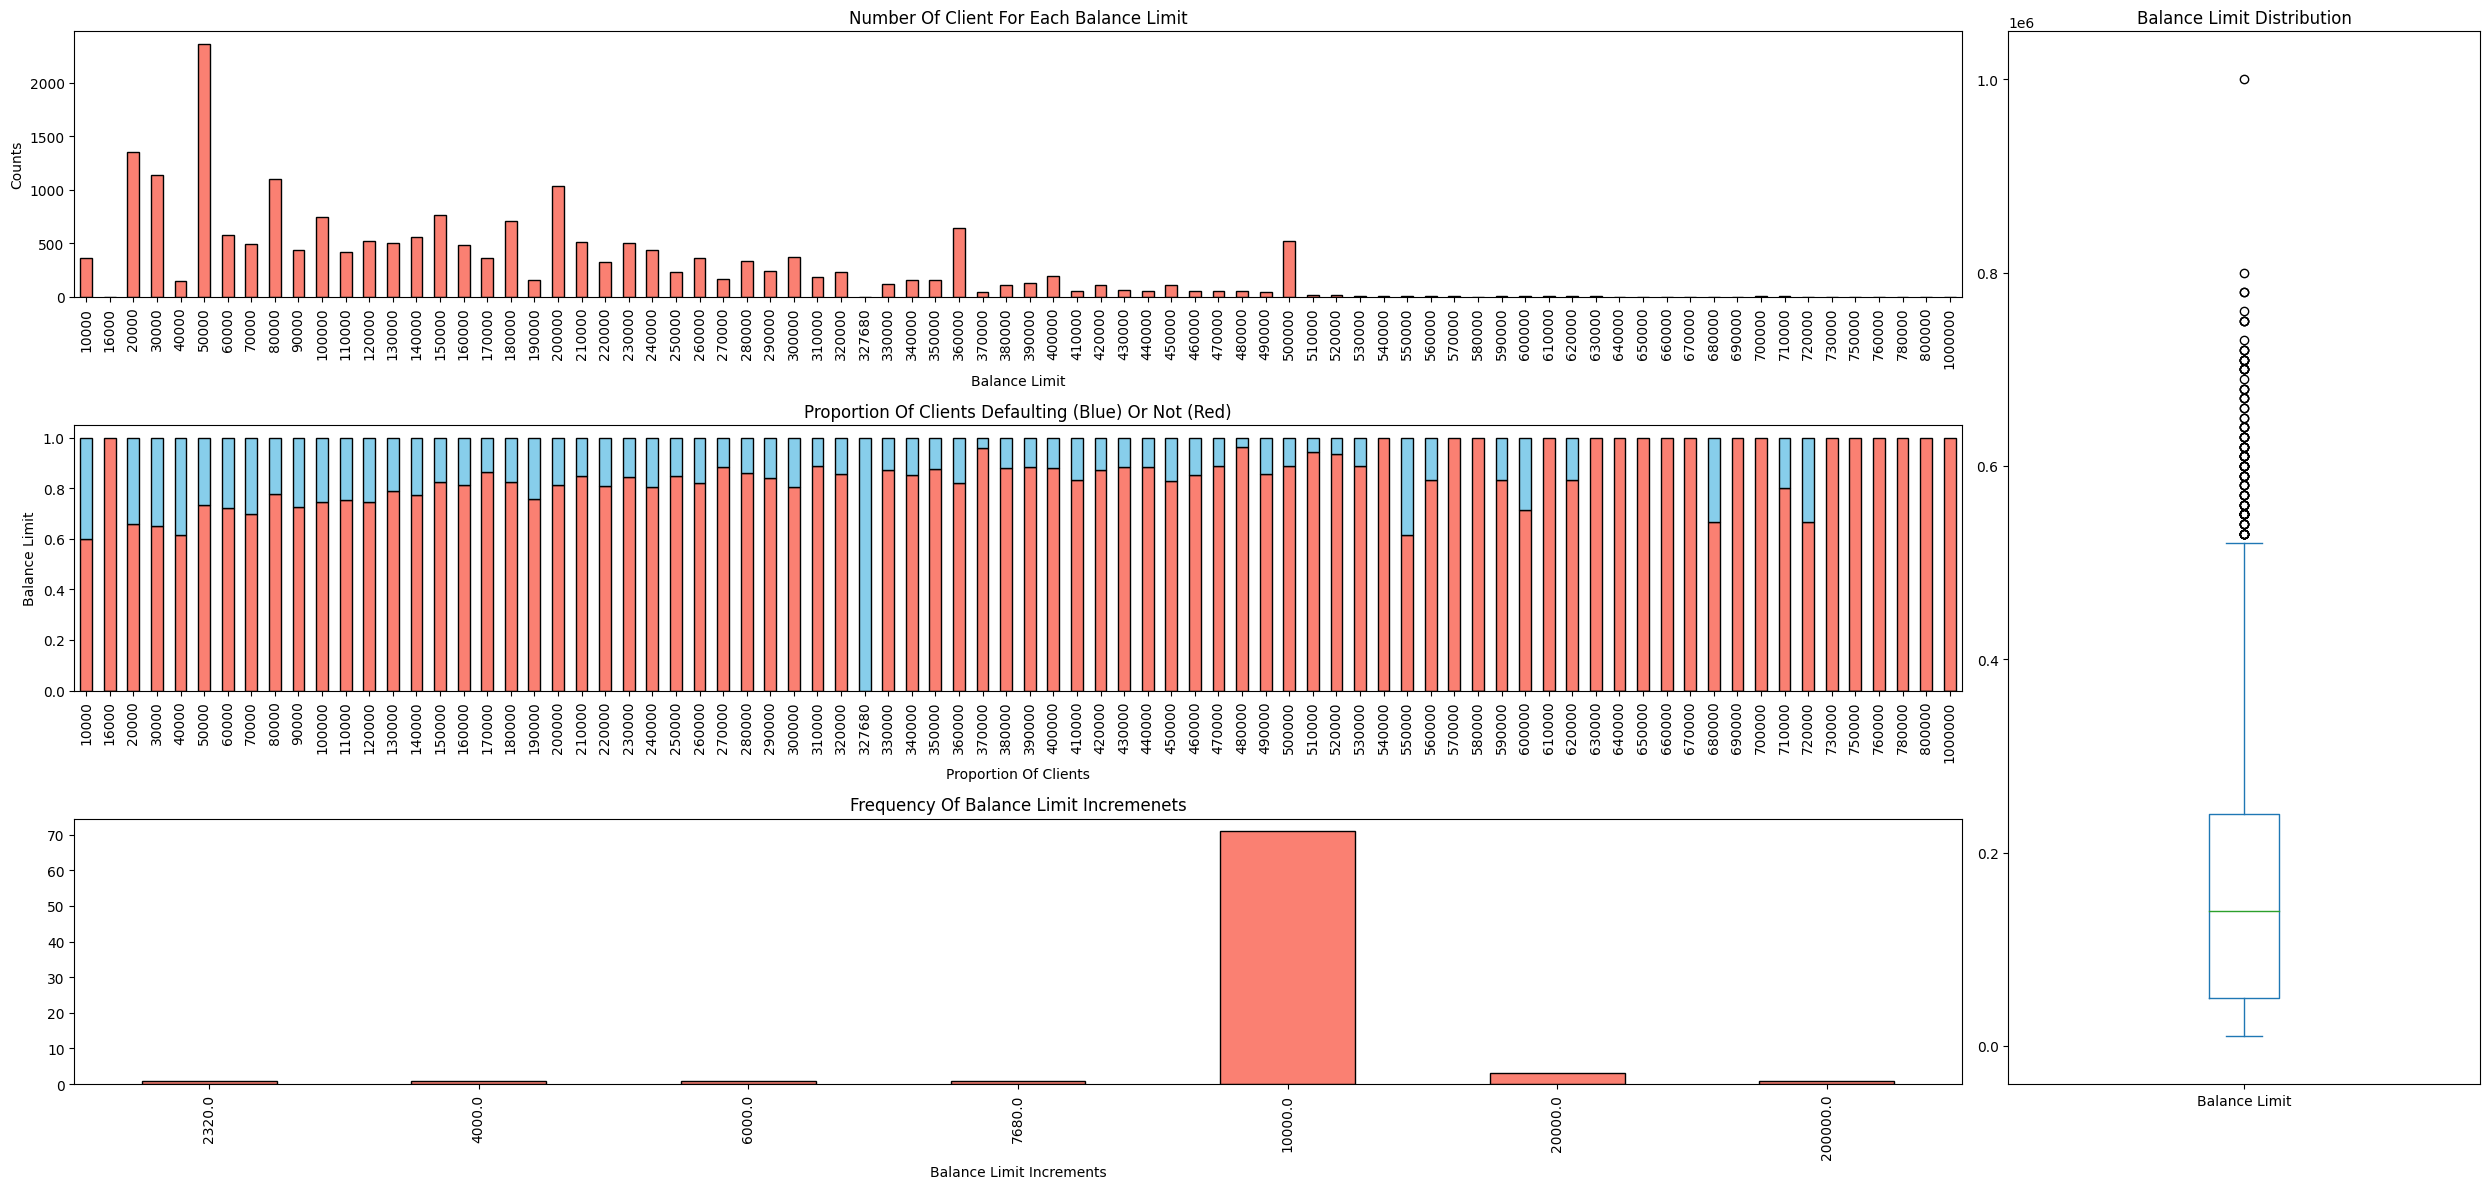

In [11]:
# Create subplots
fig, axs = plt.subplots(figsize = (25, 12), ncols = 2, nrows = 3, gridspec_kw={'width_ratios': [4, 1]})

# [Upper Left Panel] Clients per balance limit bar plot
(
    train_df['LIMIT_BAL']
        .value_counts()
        .sort_index()
        .plot.bar(
            ax = axs[0, 0],
            title = 'Number of client for each balance limit'.title(),
            ylabel = 'Counts',
            xlabel = 'Balance Limit',
            **STYLE
        )
)

# [Middle Left Panel] Default ratio by balance limit
stacked_ratios(train_df, 'LIMIT_BAL', 'default.payment.next.month').plot.bar(
    ax = axs[1, 0], 
    title = 'Proportion of clients defaulting (blue) or not (red)'.title(),
    xlabel = 'Proportion Of Clients',
    ylabel = 'Balance Limit',
    **STACKED_BAR_STYLE
)

# [Bottom Left Panel] Frequency of balance limit incremenets
(
    train_df['LIMIT_BAL']
        .sort_values()
        .diff()
        .value_counts()
        .sort_index()
        .drop(0)
        .plot.bar(
            ax = axs[2, 0],
            title = 'Frequency of balance limit incremenets'.title(),
            xlabel = 'Balance Limit Increments',
            legend = False,
            **STYLE
        )
)

# [Right Panel] Balance limit distribution
gs = axs[0, 1].get_gridspec()
for ax in axs[0:, 1]:
    ax.remove()
left_ax = fig.add_subplot(gs[0:, -1])

train_df['LIMIT_BAL'].rename('Balance Limit').plot.box(
    ax = left_ax,
    title = 'Balance Limit Distribution'.title(),
)

# Display
plt.tight_layout()

Balance limits can be grouped by their quantiles, to reduce the number of ordinal categorical variables present in the feature and to mitigate the sample size disparity between balance limits. Different quantiles have been simulated, and most show the general decrease in default proportion as balance limit increases.

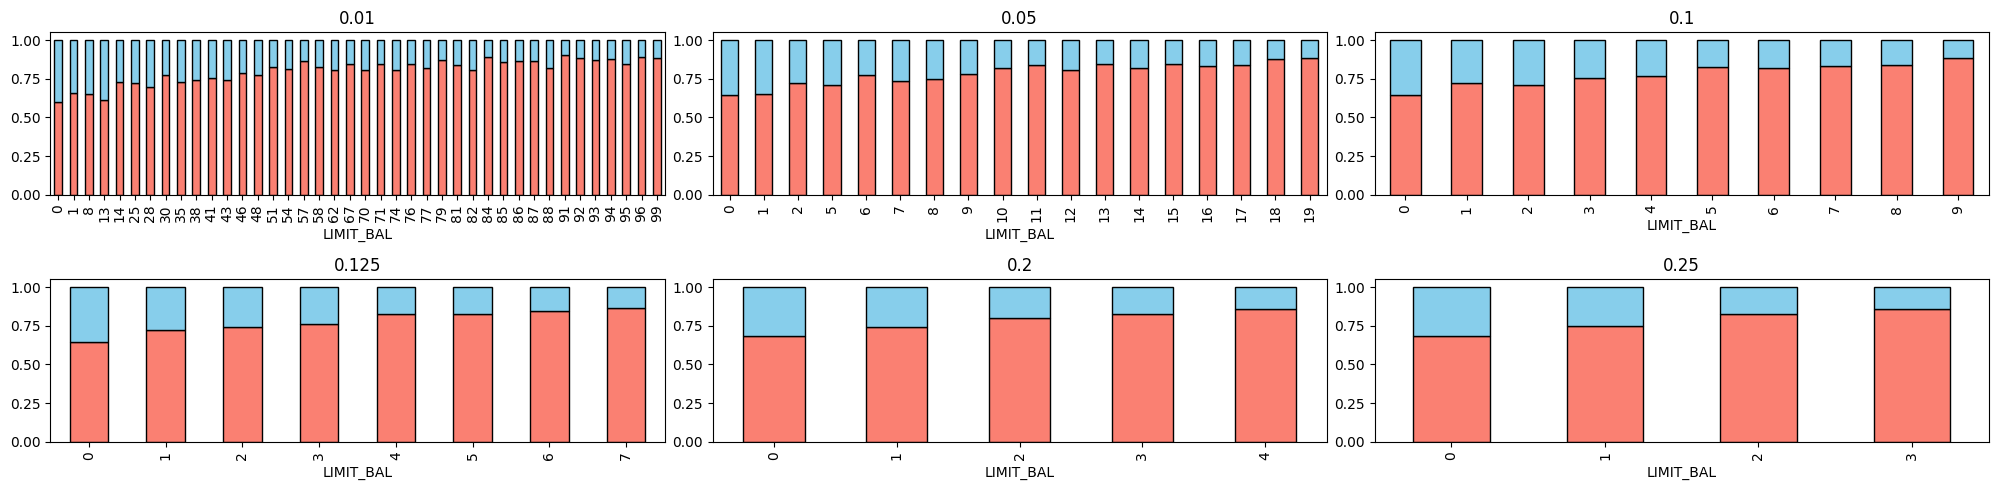

In [12]:
fig, axs = plt.subplots(figsize = (20, 5), ncols = 3, nrows = 2)

steps = np.array([0.01, 0.05, 0.1, 0.125, 0.2, 0.25])
for steps, axs in zip(steps.reshape(2, 3), axs):
    for step, ax in zip(steps, axs):
        _quantiles = quantiles(train_df['LIMIT_BAL'], np.round(step, 3))
        binned_balance_limits = quantile_binner(train_df['LIMIT_BAL'], _quantiles)
        labeled_binned_balance_limits = column_concatenation(
            binned_balance_limits,
            train_df['default.payment.next.month']
        )
        stacked_ratios(labeled_binned_balance_limits, 'LIMIT_BAL', 'default.payment.next.month').plot.bar(
            ax = ax,
            title = f'{step}', 
            **STACKED_BAR_STYLE
        )
    
plt.tight_layout()

### How does `AGE` relate to `LIMIT_BAL`?

The majority of accounts are held with clients between the ages of 26 to 30. 

However, the 21 to 25 year old group only dominates accounts from 10,000 NT to 50,000 NT dollars, in absolute counts. As the balance limit groupings increase, total number of records decreases. More interestingly, the next age group increases relative to the previous age group as balance limit increases. For example, the 26 to 30 overtakes the 21 to 25 year group at the the 5th balance limit grouping.

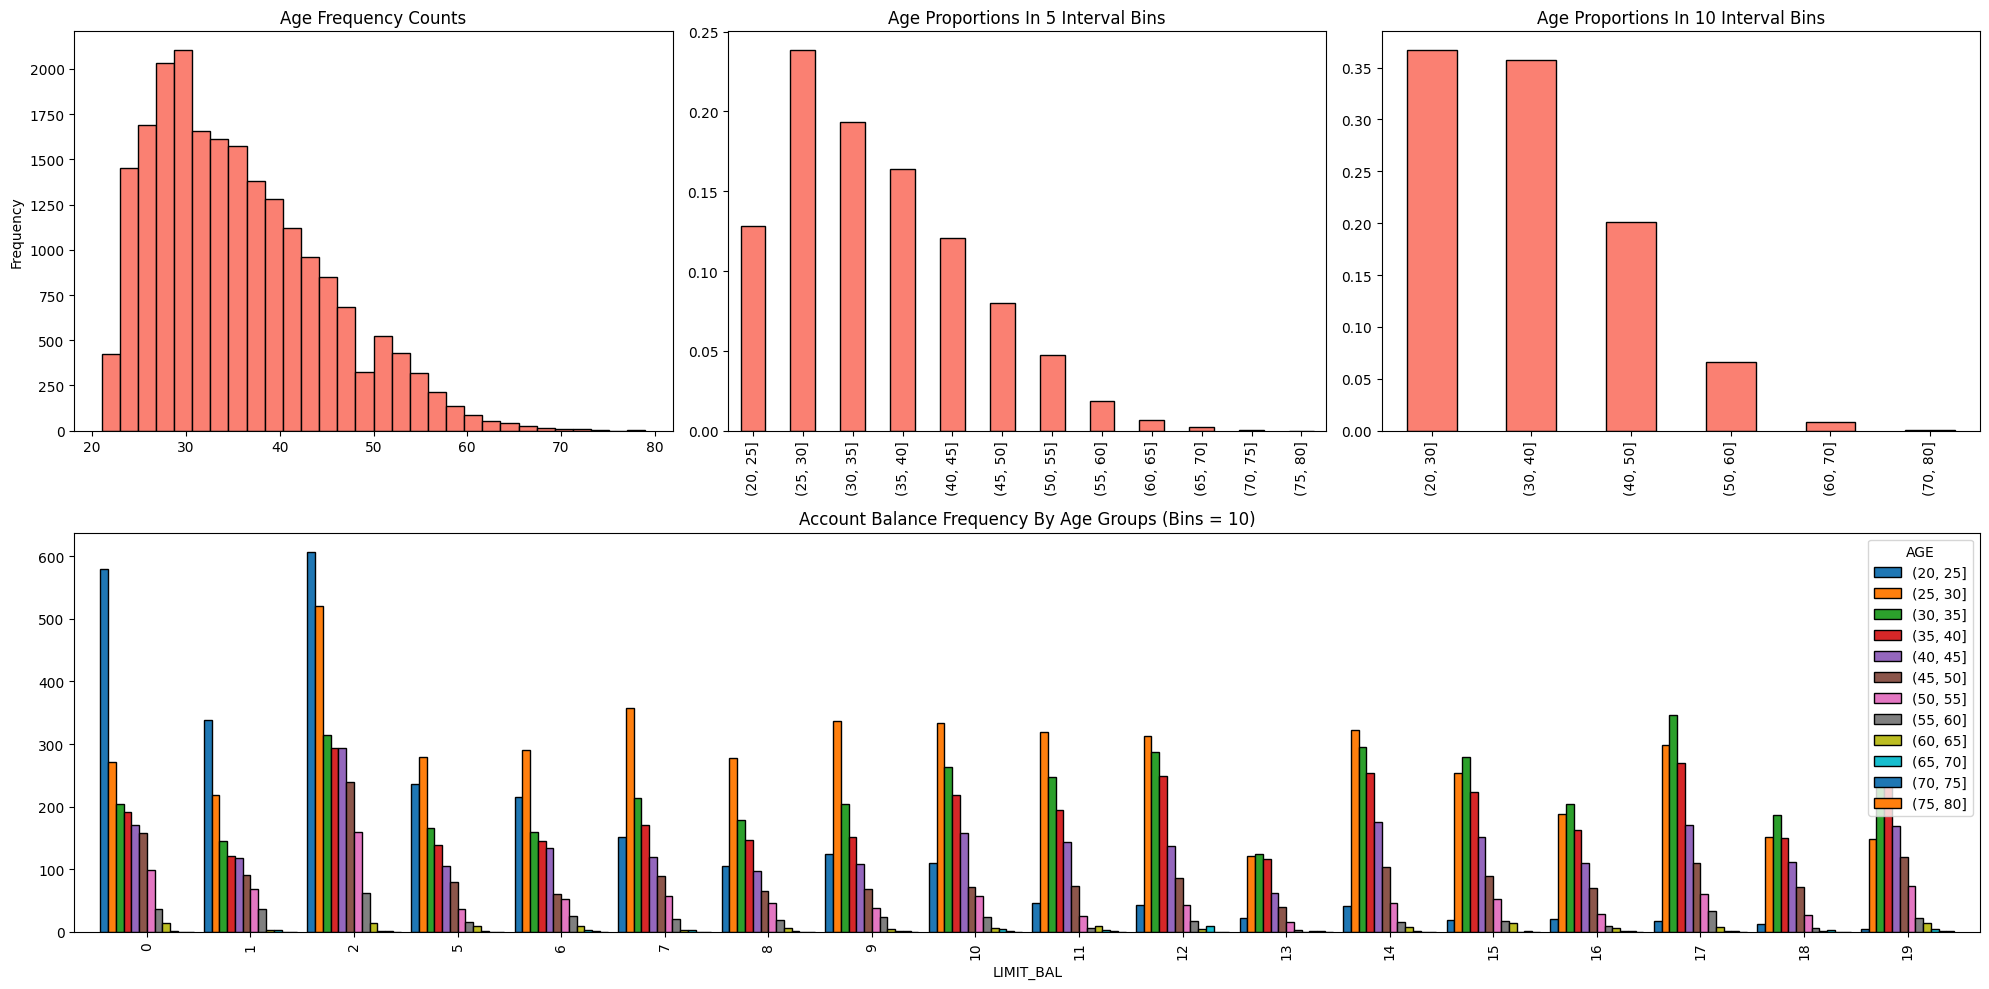

In [13]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 10))
    
interval_5_bins = range(20, 81, 5)
binned_client_age_5 = binner(train_df['AGE'], interval_5_bins)

interval_10_bins = range(20, 81, 10)
binned_client_age_10 = binner(train_df['AGE'], interval_10_bins)

# [Top Left] Age histogram
train_df['AGE'].plot.hist(
    ax = axs[0, 0],
    bins = 30,
    title = 'Age frequency counts'.title(),
    **STYLE
)

# [Top middle] Grouped age (Interval = 5)
binned_client_age_5.value_counts(normalize = True).sort_index().plot.bar(
    ax = axs[0, 1], 
    title = 'Age proportions in 5 interval bins'.title(),
    **STYLE
)

# [Top right] Grouped age (Interval = 10)
binned_client_age_10.value_counts(normalize = True).sort_index().plot.bar(
    ax = axs[0, 2], 
    title = 'Age proportions in 10 interval bins'.title(),
    **STYLE
)

# [Middle] Balance Limits (Quantiles = 0.05) vs. Age groups (Interval  = 10)
gs = axs[1, 0].get_gridspec()
for ax in axs[1, 0:]:
    ax.remove()
bottom_ax = fig.add_subplot(gs[1, 0:])

step = 0.05
_quantiles = quantiles(train_df['LIMIT_BAL'], np.round(step, 3))
binned_balance_limits = quantile_binner(train_df['LIMIT_BAL'], _quantiles)
binned_client_age_balance_limits = column_concatenation(
    binned_balance_limits,
    binned_client_age_5
)
(
    binned_client_age_balance_limits
        .groupby('AGE')
        .value_counts()
        .reset_index()
        .pivot(index = 'LIMIT_BAL', columns = 'AGE', values = 0)
        .plot.bar(
            ax = bottom_ax, 
            width = 0.9, 
            title = 'Account balance frequency by age groups (Bins = 10)'.title(),
            edgecolor = 'black'
        )
)

# Display
plt.tight_layout()

### Are certain age groups more likely to default on their credit?

The default (skyblue) proportion increases with age, when grouped by intervals of 5 and 10 years. The 5 year interval generates a 76 to 80 year old group that shows no default. Additional consideration will have to be taken whether a 5 year interval should be used given that the 76 to 80 year old group has no variance.

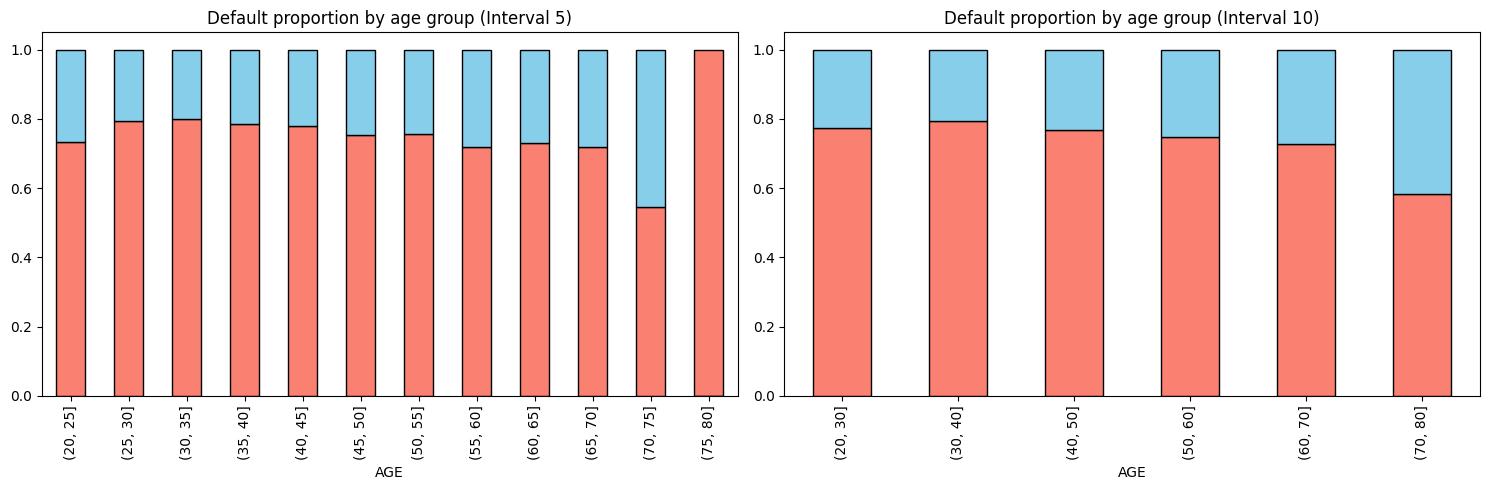

In [14]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))

labeled_age_groups = column_concatenation(
    binned_client_age_5, 
    train_df['default.payment.next.month']
)

(
    labeled_age_groups
        .groupby('AGE')
        .value_counts(normalize = True)
        .reset_index()
        .pivot(index = 'AGE', columns = 'default.payment.next.month', values = 0)
        .plot.bar(
            ax = axs[0],
            title = 'Default proportion by age group (Interval 5)',
            **STACKED_BAR_STYLE
        )
)

labeled_age_groups = column_concatenation(
    binned_client_age_10, 
    train_df['default.payment.next.month']
)

(
    labeled_age_groups
        .groupby('AGE')
        .value_counts(normalize = True)
        .reset_index()
        .pivot(index = 'AGE', columns = 'default.payment.next.month', values = 0)
        .plot.bar(
            ax = axs[1],
            title = 'Default proportion by age group (Interval 10)',
            **STACKED_BAR_STYLE
        )
)

plt.tight_layout()

### Billing/Payment Details

#### Subseting bill, payment, and difference data

The debt that a client has for a given bill cycle can calculated as the difference between the bill of a given month and that payment received for that month. If the difference is `0`, then the client has payed their debt in full`. If the difference in greater than `0`, then the client has debt remaining. A negative value would indicate that the client has overpayed.

- How does a remaining debt reflect on the client's future ability to pay the debt?
- What are client's propensity to default if they pay over more than they are billed?

In [15]:
bills = train_df.filter(regex = r'BILL_AMT\d')
payments = train_df.filter(regex = r'PAY_AMT\d')

remaining_debt = pd.DataFrame(
    data = bills.to_numpy() - payments.to_numpy(),
    columns = MONTHS,
    index = payments.index
)

remaining_debt.head()

,September,August,July,June,May,April
ID,,,,,,
16396,24026.0,23161.0,27695.0,16370.0,10155.0,-3225.0
21449,165.0,-86814.0,-42581.0,168226.0,135897.0,66207.0
20035,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0
25756,97890.0,97358.0,100490.0,100041.0,69090.0,45677.0
1439,48153.0,45485.0,25968.0,26085.0,26910.0,25880.0


#### Are there clients that go above their balance limit?

Between the months of April and September, 2% to 7% of clients have gone over their balance limit.

- Are their overdraft fees for going above a client's balance limit?
- How does a client consistently going above their balance limit reflect on their propensity to default?

In [16]:
def is_above_limit(series):
    return series > train_df['LIMIT_BAL']

bills.apply(is_above_limit).sum() / bills.shape[0]

BILL_AMT1    0.070762
BILL_AMT2    0.065238
BILL_AMT3    0.053381
BILL_AMT4    0.035143
BILL_AMT5    0.028762
BILL_AMT6    0.026857
dtype: float64

#### What proportion of clients have fully payed at least once?

Only 20% of clients have payed their debt in full in at least on billing cycle.

- What is the average debt a client carries?

In [17]:
def is_duly_payed(series):
    return series == 0

remaining_debt.apply(is_duly_payed).any(axis = 1).sum() / remaining_debt.shape[0]

0.20152380952380952

#### What proportion of clients have overpayed at least once?

About 40% of clients have payed more than they needed in at least one billing cycle.

In [18]:
def has_overpayed(series):
    return series < 0

remaining_debt.apply(has_overpayed).any(axis = 1).sum() / remaining_debt.shape[0]

0.4021904761904762

### Are there inconsistencies in the `PAY_\d` features, relative to the data documentation?

Over half (~53%) of the dataset contains an encoding that is not present in the data documentation. The `0` may refer to missing data. These features will be discarded. `-2` is another category that is undocumented. These features will be disregarded in model development, since they are poorly understood.

In [19]:
payment_status = train_df.filter(regex = 'PAY_\d')
long_status = pd.wide_to_long(payment_status.reset_index(), stubnames = 'PAY_', i = 'ID', j = 'status')
long_status.value_counts() / long_status.shape[0]

PAY_
 0      0.532492
-1      0.194048
-2      0.135349
 2      0.104230
 1      0.020563
 3      0.008206
 4      0.002524
 7      0.001183
 5      0.000817
 6      0.000437
 8      0.000151
dtype: float64

### What are the frequency counts of other categorical variables?

The clients are mostly female.

In [20]:
train_df['SEX'].value_counts(normalize = True).rename({1: 'Male', 2: 'Female'})

Female    0.600762
Male      0.399238
Name: SEX, dtype: float64

There is a majority of University graduates, with two unknown categories. The unknown categories could be collapsed into `Other`, or dropped from the data set.

In [21]:
train_df['EDUCATION'].value_counts(normalize = True).rename({
    1: 'graduate school'.title(), 
    2: 'university'.title(),
    3: 'high school'.title(),
    4: 'others'.title(),
    5: 'unknown 1'.title(),
    6: 'unknown 2'.title(),
    0: 'Missing'
})

University         0.467381
Graduate School    0.353952
High School        0.162667
Unknown 1          0.010000
Others             0.003857
Unknown 2          0.001667
Missing            0.000476
Name: EDUCATION, dtype: float64

The majority of clients are single.

In [22]:
train_df['MARRIAGE'].value_counts(normalize = True).rename({
    1: 'married'.title(),
    2: 'single'.title(),
    3: 'others'.title(),
    0: 'Missing'
})

Single     0.533810
Married    0.453667
Others     0.010905
Missing    0.001619
Name: MARRIAGE, dtype: float64

Proportion of clients that default varies by sex and marriage. It is unclear if there is a trend present, or noise.

<AxesSubplot:xlabel='SEX,MARRIAGE'>

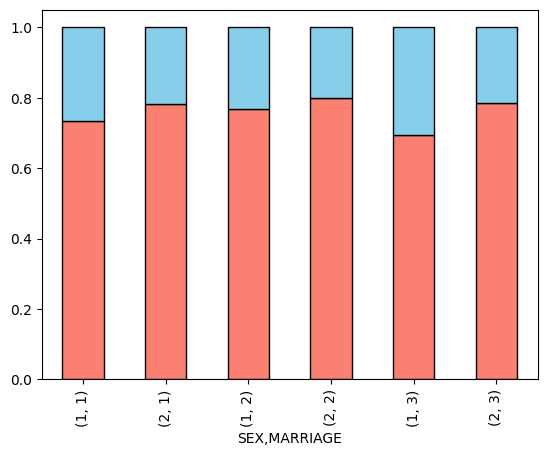

In [23]:
(
    train_df
        .query('MARRIAGE != 0')
        .groupby(['SEX', 'MARRIAGE'])['default.payment.next.month']
        .value_counts(normalize = True)
        .unstack()
        .sort_index(level = 'MARRIAGE')
        .plot.bar(**STACKED_BAR_STYLE)
)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## (Optional) 4. Feature engineering <a name='4'></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class='alert alert-warning'>
    
Solution_4
    
</div>

Features being added:
    
1. Remaining debt: The difference between the bill amount and payment received.
2. Payment status: Categorical value encoding if payment is duly, over, or under the bill amount.
3. Above balance limit: A binary feature encoding if a client has gone above their balance limit.

Clients are alos removed based on presence of missing or undocumented categories.

These operations are performed on a per client basis, and will modify the entire data set. The data will then be resplit.

In [24]:
def drop_missing(value, missing_values = [0]):
    return value in missing_values


def is_above_balance_limit(debt):
    return debt > credit_card_clients_df['LIMIT_BAL']


def remaining(df):
    bills = df.filter(regex = r'BILL_AMT\d')
    payments = df.filter(regex = r'PAY_AMT\d')
    remaining = bills.values - payments.values
    return pd.DataFrame(remaining,
                        columns = [f'REMAINING_{i}' for i in range(bills.shape[1])],
                        index = bills.index)


def payment_status(remaining_debt):
    if remaining_debt == 0:
        return 0
    elif remaining_debt > 0:
        return 1
    elif remaining_debt < 0:
        return 2

In [25]:
TO_DROP = (
    credit_card_clients_df.MARRIAGE.apply(drop_missing) 
    | credit_card_clients_df.EDUCATION.apply(partial(drop_missing, missing_values = [0, 5, 6]))
)

REMAINING = remaining(credit_card_clients_df)
PAYMENT_STATUS = (
    REMAINING
        .applymap(payment_status)
        .set_axis([f'PAY_STATUS_{i}' for i in range(REMAINING.shape[1])], axis = 1)
)

IS_ABOVE_BALANCE_LIMIT = (
    credit_card_clients_df
        .filter(regex = 'BILL_AMT\d')
        .apply(is_above_balance_limit)
        .set_axis([f'IS_ABOVE_BALANCE_LIMIT_{i}' for i in range(REMAINING.shape[1])], axis = 1)
)

feature_engineered_clients = pd.concat(
    [credit_card_clients_df, IS_ABOVE_BALANCE_LIMIT, REMAINING, PAYMENT_STATUS],
    axis = 1
).loc[~TO_DROP, :]


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name='5'></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class='alert alert-warning'>
    
Solution_5
    
</div>

In [26]:
X = feature_engineered_clients.drop(columns = ['default.payment.next.month'])
y = feature_engineered_clients['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 123)

In [27]:
DROP = [
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

UNIFORM_BINNING = ['AGE']
QUANTILE_BINNING = ['LIMIT_BAL']

ORDINAL = ['EDUCATION']
NOMINAL = [
    'MARRIAGE', 'SEX', 
    'PAY_STATUS_0', 'PAY_STATUS_1', 'PAY_STATUS_2', 
    'PAY_STATUS_3', 'PAY_STATUS_4', 'PAY_STATUS_5'
]
BINARY = [
    'IS_ABOVE_BALANCE_LIMIT_0', 'IS_ABOVE_BALANCE_LIMIT_1', 
    'IS_ABOVE_BALANCE_LIMIT_2', 'IS_ABOVE_BALANCE_LIMIT_3', 
    'IS_ABOVE_BALANCE_LIMIT_4', 'IS_ABOVE_BALANCE_LIMIT_5'
]

preprocessor = make_column_transformer(
    (OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ORDINAL),
    (KBinsDiscretizer(n_bins = 12, encode = 'ordinal', strategy = 'uniform'), UNIFORM_BINNING),
    (KBinsDiscretizer(n_bins = 15, encode = 'ordinal', strategy = 'quantile', subsample = None), QUANTILE_BINNING),
    (OneHotEncoder(), NOMINAL),
    (OneHotEncoder(drop = 'first'), BINARY),
    ('drop', DROP)
)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name='6'></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class='alert alert-warning'>
    
Solution_6
    
</div>

The dummy variable has an F1 score of 0.

In [28]:
pipe_dummy = make_pipeline(
    preprocessor,
    DummyClassifier(strategy = 'most_frequent')
)
pipe_dummy.fit(X_train, y_train)
print('Dummy F1 Score:', f1_score(y_validation, pipe_dummy.predict(X_validation)))

Dummy F1 Score: 0.0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name='7'></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class='alert alert-warning'>
    
Solution_7
    
</div>

The mean cross validation F1 score is 0.418 +/- 0.007. A logistic regression model appears to be stable across multiple fold of the training set as observed by the low standard deviation. However, the F1 score is lower than desireable.

In [29]:
pipe_logit = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter = 3_000, class_weight = 'balanced'),
)
pipe_logit.fit(X_train, y_train)
pr_cross_validation(pipe_logit, X_train, y_train)[['test_f1']].agg([np.mean, np.std])

,test_f1
mean,0.418248
std,0.006551


When the regularatization hyperparamter `C` is selected randomly from values between 0.01 and 1,000, the f1 score or the standard deviation does not with the hyperparameter. 

In other words, the model's f1 score is stable across multiple hyperparameters.

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


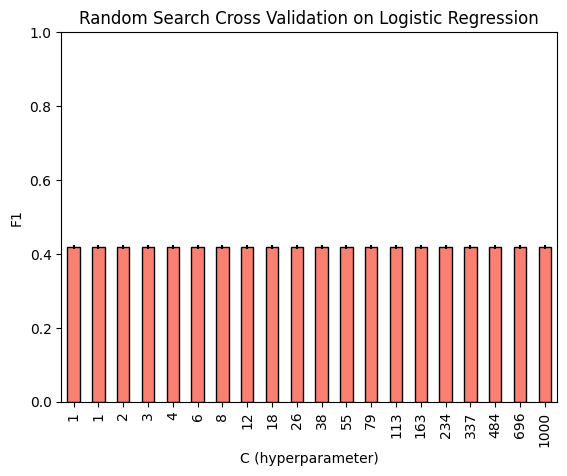

In [30]:
param_grid = {
    'logisticregression__C': np.logspace(0.01, 3, 20, endpoint = True, dtype = np.int32)
}
logit_search = pr_random_search_cv(pipe_logit, X_train, y_train, param_grid)

(
    pd.DataFrame(logit_search.cv_results_)
        .set_index('param_logisticregression__C')
        .loc[:, ['mean_test_f1', 'std_test_f1']]
        .plot.bar(
            yerr = 'std_test_f1',
            legend = False,
            xlabel = 'C (hyperparameter)',
            ylabel = 'F1',
            ylim = (0, 1),
            title = 'Random Search Cross Validation on Logistic Regression',
            **STYLE
        )
)
plt.show()

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name='8'></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class='alert alert-warning'>
    
Solution_8
    
</div>

In [31]:
models = {
    'Logistic': {
        'class': LogisticRegression,
        'params': {'max_iter': 3_000, 'class_weight': 'balanced'}
    },
    'SVM': {
        'class': SVC,
        'params': {'probability': True, 'class_weight': 'balanced'}
    },
    'Random Forest': {
        'class': RandomForestClassifier,
        'params': {'n_jobs': -1, 'class_weight': 'balanced'}
    },
    'KNN': {
        'class': KNeighborsClassifier,
        'params': {'n_neighbors': 5}
    },
    'CatBoost': {
        'class': CatBoostClassifier,
        'params': {'verbose': 0, 'random_state': 123, 'class_weights': class_weights(y_train)}
    }
}

model_results = {}
for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        model['class'](**model['params'])
    )
    print(name)
    model_results[name] = pr_cross_validation(pipe, X_train, y_train, n_jobs = -1)

Logistic
SVM
Random Forest
KNN
CatBoost


In [32]:
cv_results = (
    pd.concat(model_results.values(), axis = 0)
        .set_axis(chain.from_iterable(zip(*[model_results.keys()] * 5)))
        .reset_index()
        .rename({'index': 'model'}, axis = 1)
)

The best cross validated model is SVM with RBF kernel with a F1 score of 0.421 +/- 0.009. Logistic regression is marginally lesser. A logistic regression may be superior to the SVM with RBF kernel classifier, given that SVM has a high fit time (22.921 +/-  0.216 seconds) and scoring time (1.912 +/- 0.045) seconds). Therefore, a logistic regression would be better suited if real time predictions are needed.

                   mean       std
model                            
CatBoost       0.409277  0.013575
KNN            0.195100  0.024869
Logistic       0.418248  0.006551
Random Forest  0.291526  0.016595
SVM            0.421182  0.009333


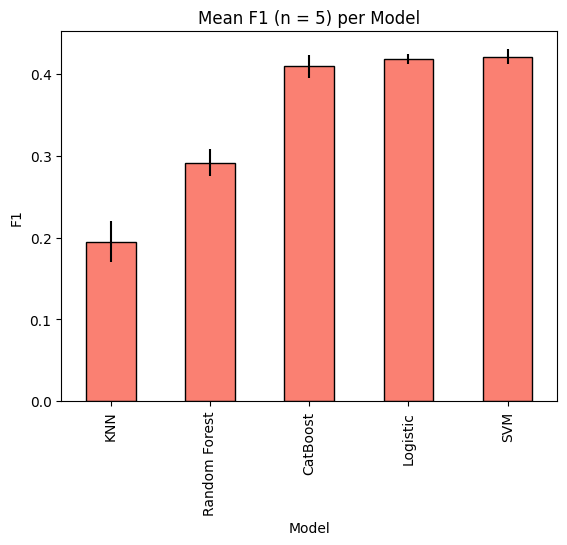

In [33]:
summarized_cv_results = (
    cv_results
        .groupby('model')
        .test_f1
        .agg([np.mean, np.std])
)

print(summarized_cv_results)

summarized_cv_results.sort_values('mean').plot.bar(
    yerr = 'std',
    xlabel = 'Model',
    ylabel = 'F1',
    title = 'Mean F1 (n = 5) per Model',
    legend = False,
    **STYLE
)
plt.show()

Fit time:
                    mean       std
model                             
KNN             0.025011  0.004386
Logistic        0.119779  0.014421
Random Forest   0.863987  0.012049
CatBoost        7.930788  0.277457
SVM            27.208909  0.432610

Scoring time:
                   mean       std
model                            
Logistic       0.022397  0.006823
CatBoost       0.026859  0.002682
Random Forest  0.059022  0.010174
KNN            0.160530  0.003803
SVM            2.266066  0.135114


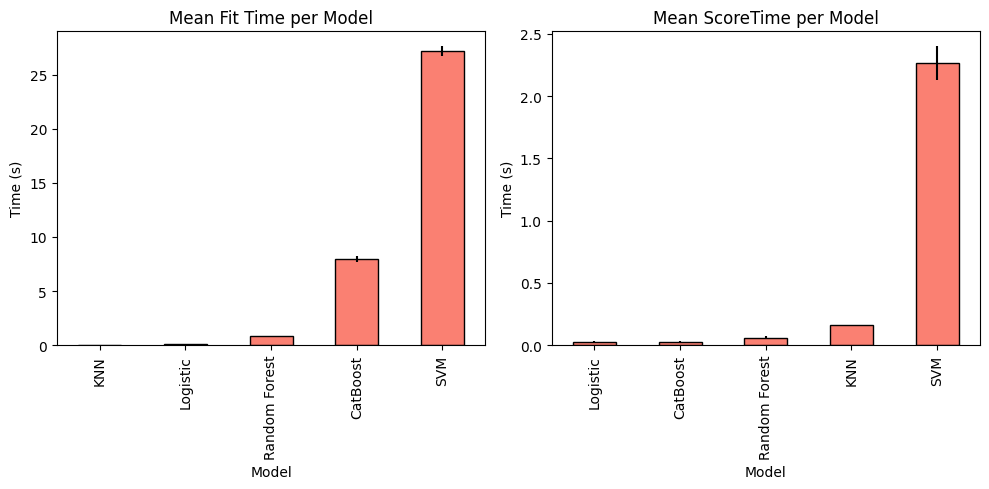

In [34]:
summarized_cv_timing = (
    cv_results
        .loc[:, ['model', 'fit_time', 'score_time']]
        .groupby('model')
        .agg([np.mean, np.std])
)

fit_time = summarized_cv_timing['fit_time'].sort_values('mean')
scoring_time = summarized_cv_timing['score_time'].sort_values('mean')

print('Fit time:')
print(fit_time, end = '\n\n')
print('Scoring time:')
print(scoring_time)

fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))

fit_time.plot.bar(yerr = 'std', title = 'Mean Fit Time per Model', ax = axs[0], legend = False, **STYLE)
scoring_time.plot.bar(yerr = 'std', title = 'Mean ScoreTime per Model', ax = axs[1], legend = False, **STYLE)

for ax in axs:
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Model')

plt.tight_layout()

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## (Optional) 9. Feature selection <a name='9'></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class='alert alert-warning'>
    
Solution_9
    
</div>

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name='10'></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class='alert alert-warning'>
    
Solution_10
    
</div>

### `RandomForestClassifier`

In [35]:
pipe_rfc = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state = 123, class_weight = 'balanced')
)

param_grid = {
    'randomforestclassifier__n_estimators': np.arange(10, 101, 10),
    'randomforestclassifier__max_depth': np.arange(5, 15),
    'randomforestclassifier__max_features': np.arange(1, 4)
}

random_search = pr_random_search_cv(
    pipe_rfc, 
    X_train,
    y_train,
    param_grid,
)
rfc_search = random_search.fit(X_train, y_train)
print('Best F1 Score: ', rfc_search.best_score_)
print(rfc_search.best_params_)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best F1 Score:  0.42094423169577216
{'randomforestclassifier__n_estimators': 60, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__max_depth': 6}


The F1 score on the validation set is similar to that of the training set, suggesting that over or underfitting may not be occurring.

In [36]:
f1_score(y_validation, rfc_search.predict(X_validation))

0.4088185957344836

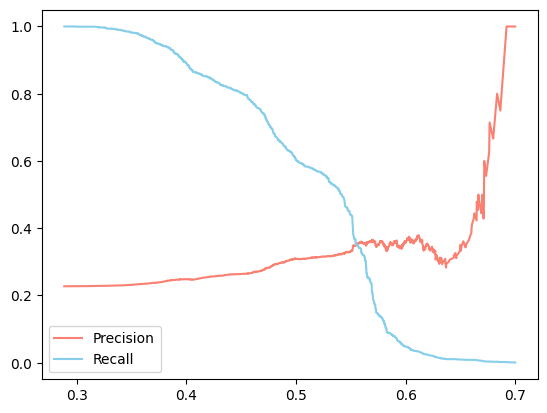

In [37]:
fig, ax = plt.subplots()
precision_recall_plot(rfc_search, X_validation, y_validation, ax = ax)
plt.show()

In [38]:
report(y_validation, rfc_search.predict_proba(X_validation)[:, 1], 0.35)

     0     1
0  201  4602
1   26  1387

              precision    recall  f1-score   support

  No Default       0.89      0.04      0.08      4803
     Default       0.23      0.98      0.37      1413

    accuracy                           0.26      6216
   macro avg       0.56      0.51      0.23      6216
weighted avg       0.74      0.26      0.15      6216



### `CatBoostClassifier`

In [39]:
pipe_catboost = make_pipeline(
    preprocessor,
    CatBoostClassifier(verbose = 0, random_state = 123, class_weights = class_weights(y_train))
)

param_grid = {
    'catboostclassifier__n_estimators': np.arange(10, 101, 10),
    'catboostclassifier__max_depth': np.arange(5, 11),
    'catboostclassifier__learning_rate': np.linspace(0.05, 0.4, 10)
}

random_search = pr_random_search_cv(
    pipe_catboost,
    X_train,
    y_train,
    param_grid
)
catboost_search = random_search.fit(X_train, y_train)
print('Best F1 Score: ', catboost_search.best_score_)
print(catboost_search.best_params_)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best F1 Score:  0.42014528984928773
{'catboostclassifier__n_estimators': 80, 'catboostclassifier__max_depth': 6, 'catboostclassifier__learning_rate': 0.08888888888888889}


In [40]:
f1_score(y_validation, catboost_search.predict(X_validation))

0.4156881164866134

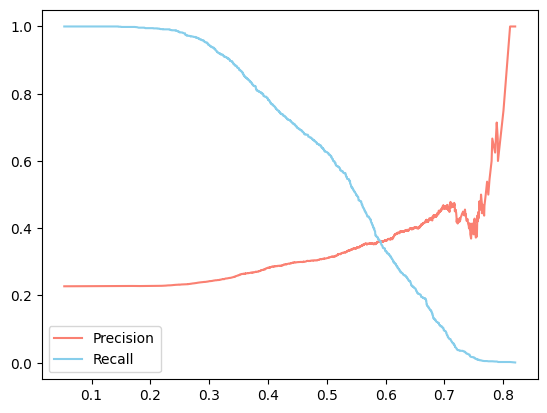

In [41]:
fig, ax = plt.subplots()
precision_recall_plot(catboost_search, X_validation, y_validation, ax = ax)
plt.show()

If the threshold for positivity is set to `0.35`, then the recall increases from 0.63 to 0.88, precision decreases 0.31 to 0.26, and the F1 score decreases to 0.40. The acceptable recall and precision will have to be determined according to business needs.

In [42]:
report(y_validation, catboost_search.predict_proba(X_validation)[:, 1], 0.35)

      0     1
0  1289  3514
1   176  1237

              precision    recall  f1-score   support

  No Default       0.88      0.27      0.41      4803
     Default       0.26      0.88      0.40      1413

    accuracy                           0.41      6216
   macro avg       0.57      0.57      0.41      6216
weighted avg       0.74      0.41      0.41      6216



<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name='1'></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class='alert alert-warning'>
    
Solution_11
    
</div>

### Retrieving Feature Names

In [43]:
feature_names_out = []
for _, transformer in rfc_search.best_estimator_.named_steps['columntransformer'].named_transformers_.items():
    if transformer == 'drop':
        continue
    feature_names_out.extend(transformer.get_feature_names_out().tolist())

### Feature Importance: `CatBoostClassifier`

The `LIMIT_BAL` feature is the most important feature according to the `eli5` package. The `LIMIT_BAL` feature's weight stands at an order of magnitude greater than all other features. Other important features include `AGE` and `EDUCATION`. A different binning strategy for `LIMIT_BAL` and `AGE` may impact their calculate weights.

In [44]:
eli5.explain_weights(catboost_search.best_estimator_.named_steps['catboostclassifier'], feature_names = feature_names_out)

Weight,Feature
0.2633,LIMIT_BAL
0.0927,AGE
0.0728,EDUCATION
0.0442,PAY_STATUS_1_2
0.0352,PAY_STATUS_4_1
0.0334,IS_ABOVE_BALANCE_LIMIT_1_True
0.0330,PAY_STATUS_3_2
0.0272,MARRIAGE_1
0.0265,PAY_STATUS_0_2
0.0261,PAY_STATUS_5_2


`LIMIT_BAL` is identified as the most important feature when observing mean SHAP values. Other features do not align between `eli5` and `shap`. However, the alignmnet in `LIMIT_BAL` may highlight how influential this feature is in the model.

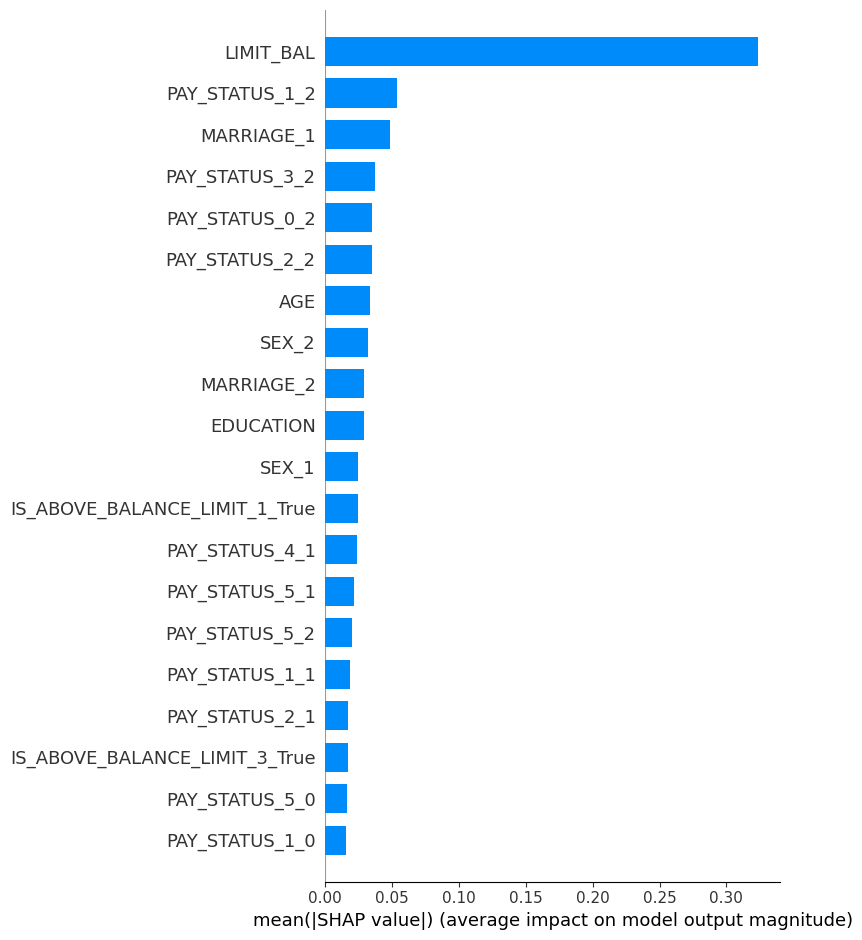

In [45]:
X_train_enc = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns = feature_names_out
)
X_validation_enc = pd.DataFrame(
    preprocessor.transform(X_validation),
    columns = feature_names_out
)

shap.initjs()
train_catboost_explainer = shap.TreeExplainer(catboost_search.best_estimator_.named_steps['catboostclassifier'])
train_shap_values = train_catboost_explainer.shap_values(X_train_enc)

shap.summary_plot(train_shap_values, X_train_enc, plot_type="bar")

The below view of are SHAP value distribution by feature. The most important features are at the top, and appear to have high concordance between high and low feature values along with negative or positive SHAP values. Other features do not have the same ability to discriminate, suggesting that they may not provide as much information to the model in its current configuration.

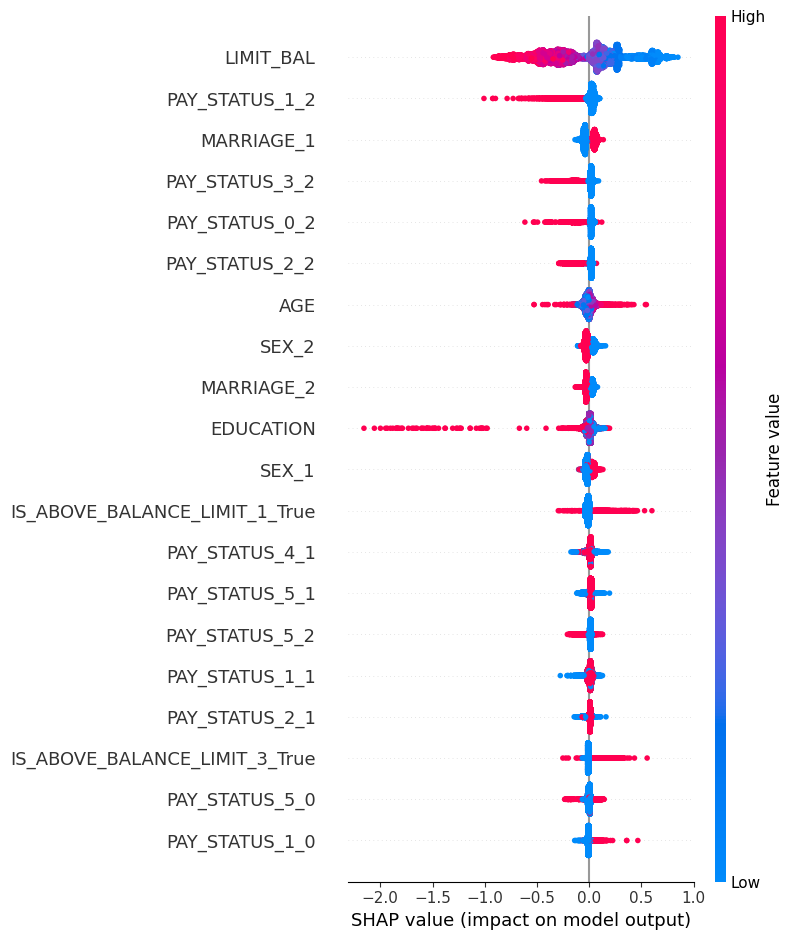

In [46]:
shap.summary_plot(train_shap_values, X_train_enc)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name='12'></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class='alert alert-warning'>
    
Solution_12
    
</div>

The main data set is split again so that the train and validation set are combined. The combination of the two data sets will be used to train the final model. 

The F1 score of a threshold set to 0.5 is 0.404, which is not too dissimilar from the F1 scores obtained in training and validation. Decreasing the threshold to 0.35, decreases the F1 score to 0.394, but increases the recall from 0.61 to 0.90.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
catboost_pipe = make_pipeline(
    preprocessor,
    CatBoostClassifier(
        verbose = 0,
        random_state = 123,
        class_weights = class_weights(y_train),
        n_estimators = 80, 
        max_depth = 6, 
        learning_rate = 0.08888888888888889
    )
)

catboost_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['EDUCATION']),
                                                 ('kbinsdiscretizer-1',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=12,
                                                                   strategy='uniform'),
                                                  ['AGE']),
                                                 ('kbinsdiscretizer-2',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=15,
                                                                   subsample=None),
                                                  ['L...
                                                   'IS_ABOVE_BALANCE_LIMIT_3',
                                                   'IS_ABOVE_BALANCE_LIMIT_4',
                                                   'IS_ABOVE_BALANCE_LIMIT_5']),
                                                 ('drop', 'drop',
                                                  ['PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5',
                                                   'PAY_6'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x2888470a0>)])

In [48]:
THRESHOLD = 0.5
probabilities = catboost_pipe.predict_proba(X_test)[:, 1]
f1_score(y_test, probabilities > THRESHOLD)

0.4047619047619047

In [49]:
report(y_test, probabilities, THRESHOLD)

      0     1
0  4191  2754
1   746  1190

              precision    recall  f1-score   support

  No Default       0.85      0.60      0.71      6945
     Default       0.30      0.61      0.40      1936

    accuracy                           0.61      8881
   macro avg       0.58      0.61      0.56      8881
weighted avg       0.73      0.61      0.64      8881



In [50]:
THRESHOLD = 0.35
probabilities = catboost_pipe.predict_proba(X_test)[:, 1]
f1_score(y_test, probabilities > THRESHOLD)

0.3941390277146752

In [51]:
report(y_test, probabilities, THRESHOLD)

      0     1
0  1812  5133
1   201  1735

              precision    recall  f1-score   support

  No Default       0.90      0.26      0.40      6945
     Default       0.25      0.90      0.39      1936

    accuracy                           0.40      8881
   macro avg       0.58      0.58      0.40      8881
weighted avg       0.76      0.40      0.40      8881



In [52]:
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = pd.DataFrame(preprocessor.transform(X_test), columns = feature_names_out)

test_catboost_explainer = shap.TreeExplainer(catboost_pipe.named_steps['catboostclassifier'])
test_shap_values = test_catboost_explainer.shap_values(X_test_enc)

y_test_reset = y_test.reset_index(drop = True)
default_examples = y_test_reset[y_test_reset == 1].index.tolist()
no_default_examples = y_test_reset[y_test_reset == 0].index.tolist()

The strongest force that is influencing the prediciton for the below force plot is `LIMIT_BAL`, as it has the greater length. The magnitude of the `LIMIT_BAL` force is pushing the model to the positive value.

In [53]:
EXAMPLE_IDX = 10
shap.force_plot(
    test_catboost_explainer.expected_value,
    test_shap_values[default_examples[EXAMPLE_IDX]],
    X_test_enc.iloc[default_examples[EXAMPLE_IDX], :]
)

Once more, the greatest force in the force plot corresponds to `LIMIT_BAL`, with the second largest force being `AGE`. This time, the forces are pushing towards a negative value.

In [54]:
EXAMPLE_IDX = 1
shap.force_plot(
    test_catboost_explainer.expected_value,
    test_shap_values[no_default_examples[EXAMPLE_IDX]],
    X_test_enc.iloc[no_default_examples[EXAMPLE_IDX], :]
)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name='13'></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class='alert alert-warning'>
    
Solution_13
    
</div>

Below is a table summarizing the F1 scores for the train and test data sets used on the final model. The table highlights the difference in F1 score between a threshold of 0.5 and 0.35. 

The test set maintains a similar F1 score in both 0.5 and 0.35. The test sets values are lower than the training set, as expected, but not dramatically. Therefore, we may not be overfitting on the data.

In [55]:
pd.DataFrame({
    'train_f1_050': [f1_score(y_train, catboost_pipe.predict_proba(X_train)[:, 1] > 0.5)],
    'train_f1_035': [f1_score(y_train, catboost_pipe.predict_proba(X_train)[:, 1] > 0.35)],
    'test_f1_050': [f1_score(y_test, catboost_pipe.predict_proba(X_test)[:, 1] > 0.5)],
    'test_f1_035': [f1_score(y_test, catboost_pipe.predict_proba(X_test)[:, 1] > 0.35)],
})

,train_f1_050,train_f1_035,test_f1_050,test_f1_035
0,0.446634,0.411765,0.404762,0.394139


2. The `CatBoostClassifier` performs well when the threshold is modified to 0.35 to label a client as `default`. However, there is still low precision, and other methods may need to be explored to ensure that the clients that are being labelled as `default` have a true propensity to defaul. Feature selection may help further refine the model.
3. The model may be improved by calculating additional features that capture the interactions between features that are already present in the data set. An ensemble using different types of models may also be useful, as to make sure that multiple, orthogonal, learning algorithms concur or not on a prediction.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## (Optional) 14. Your takeaway <a name='15'></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class='alert alert-warning'>
    
Solution_14
    
</div>

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from '1' will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Congratulations on finishing this project. This was a tricky one but you did it!

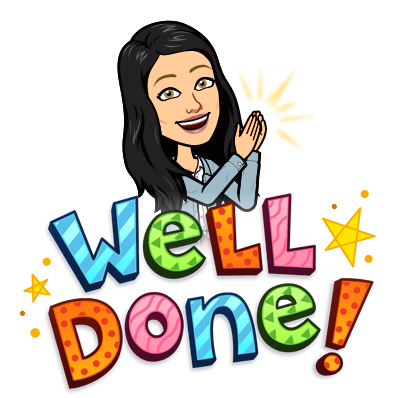

In [56]:
from IPython.display import Image

Image('img/eva-well-done.png')